Import google drive on colab (Skip this cell if you download the model locally)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Import libraries

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.models import swin_s, Swin_S_Weights
from torchvision.datasets import ImageFolder
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

Check device (cpu is recommended for this notebook)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Define model architecture (same as the training script). Load model weights from the saved .pth file from the training script. Make sure to upload the file to Google Drive before loading.

In [ ]:
pretrained_swin = swin_s()
pretrained_swin_weights = Swin_S_Weights.DEFAULT
pretrained_swin.head = nn.Sequential(
    nn.Linear(pretrained_swin.head.in_features, 128),
    nn.ReLU(),
    nn.Dropout(0.25),
    nn.Linear(128,4),
    nn.Softmax(-1)
)

# Change model_path to the location of the swin_frozenbody_final.pth file
model_path = 'drive/MyDrive/swin_frozenbody_final.pth'
checkpoint = torch.load(model_path,map_location = torch.device('cpu'))

pretrained_swin.load_state_dict(checkpoint)


<All keys matched successfully>

Set the test data directory and create test loader.

In [ ]:
batch_size = 64

# Change test_dir to the Testing folder path
test_dir = 'drive/MyDrive/Dataset/archive/Testing'
test_data = ImageFolder(root = test_dir, transform = pretrained_swin_weights.transforms())
test_loader = DataLoader(test_data, batch_size = batch_size, shuffle = False)

Save the prediction for evaluation

In [ ]:
pretrained_swin.eval()

correct = 0
total = 0
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        outputs = pretrained_swin(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        y_true.extend(labels.numpy())
        y_pred.extend(predicted.numpy())

test_accuracy = correct / total



In [ ]:
print(f"Test Accuracy: {test_accuracy}")

Test Accuracy: 0.9740655987795576


Create confusion matrix and calculate accuracy, f1-score, precision, recall.

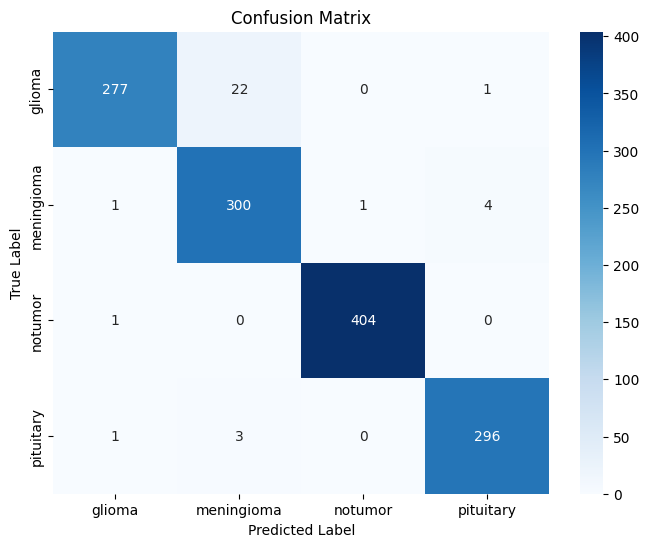

In [ ]:
true_label = []
pred_label = []
for i in y_true:
    true_label.append(i)

for i in y_pred:
    pred_label.append(i)

true_label = np.array(true_label)
pred_label = np.array(pred_label)
# Generate confusion matrix
conf_matrix = confusion_matrix(true_label, pred_label)

# Plot confusion matrix
labels = ['glioma', 'meningioma', 'notumor', 'pituitary']

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
print(classification_report(true_label, pred_label))

              precision    recall  f1-score   support

           0       0.99      0.92      0.96       300
           1       0.92      0.98      0.95       306
           2       1.00      1.00      1.00       405
           3       0.98      0.99      0.99       300

    accuracy                           0.97      1311
   macro avg       0.97      0.97      0.97      1311
weighted avg       0.98      0.97      0.97      1311

